In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import mlflow
import mlflow.sklearn

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Importing Important Libraries

import numpy as np # for mathematical computation
import pandas as pd # for dealing with the data
import matplotlib.pyplot as plt # for visualization
import seaborn as sns # for visualization
%matplotlib inline

In [11]:

import configparser
path_root="/home/cdsw"
USER_PREFIX='JVP'

config = configparser.ConfigParser()
config.read(f"{path_root}/parameters.conf")
data_lake_name=config.get("general","data_lake_name")
s3BucketName=config.get("general","s3BucketName")
train_tablename=config.get("general","train_tablename")
test_tablename=config.get("general","test_tablename")
database =f"{USER_PREFIX}_{config.get('general','database')}"
srcdir=s3BucketName

In [5]:
# Click on the Data icon at the top of the window 
# Then click the "Spark Data Lake" button
# Finally click on the "Copy code" button and paste the contents below.

import cml.data_v1 as cmldata

# Sample in-code customization of spark configurations
#from pyspark import SparkContext
#SparkContext.setSystemProperty('spark.executor.cores', '1')
#SparkContext.setSystemProperty('spark.executor.memory', '2g')

CONNECTION_NAME = "jqrhv9chljtm"
conn = cmldata.get_connection(CONNECTION_NAME)
spark = conn.get_spark_session()

# Sample usage to run query through spark
EXAMPLE_SQL_QUERY = "show databases"
spark.sql(EXAMPLE_SQL_QUERY).show()


Setting spark.hadoop.yarn.resourcemanager.principal to csso_jprosser


Spark Application Id:spark-application-1727288566385


Hive Session ID = dd5095cf-9c0c-4c29-af8c-e654217c1aef


+------------------+
|         namespace|
+------------------+
|           default|
|information_schema|
| jvp_cc_lead_model|
|               sys|
+------------------+



In [6]:
from __future__ import print_function
import os
import sys
from pyspark.sql import SparkSession
import time

In [13]:
spark = (
  SparkSession.builder.appName(f"{USER_PREFIX}_CCLead-Data-Loader")
  .config("spark.sql.hive.hwc.execution.mode", "spark")
  .config("spark.sql.extensions", "com.qubole.spark.hiveacid.HiveAcidAutoConvertExtension, org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions")
  .config("spark.sql.catalog.spark_catalog.type", "hive")
  .config("spark.sql.catalog.spark_catalog", "org.apache.iceberg.spark.SparkSessionCatalog")
  .config("spark.yarn.access.hadoopFileSystems", data_lake_name)
  .config("spark.hadoop.iceberg.engine.hive.enabled", "true")
  .config("spark.jars", "/opt/spark/optional-lib/iceberg-spark-runtime.jar")
  .getOrCreate()
  )



In [14]:
# Sample usage to run query through spark
EXAMPLE_SQL_QUERY = "show databases"
spark.sql(EXAMPLE_SQL_QUERY).show()
spark.sql(f"SELECT * FROM {database}.{train_tablename}.snapshots").show();

+------------------+
|         namespace|
+------------------+
|           default|
|information_schema|
| jvp_cc_lead_model|
|               sys|
+------------------+



+--------------------+-------------------+-------------------+---------+--------------------+--------------------+
|        committed_at|        snapshot_id|          parent_id|operation|       manifest_list|             summary|
+--------------------+-------------------+-------------------+---------+--------------------+--------------------+
|2024-09-25 17:58:...|7358846949846510102|               null|   append|s3a://jqrhv9chljt...|{spark.app.id -> ...|
|2024-09-25 18:01:...|  21885554618766449|7358846949846510102|   append|s3a://jqrhv9chljt...|{spark.app.id -> ...|
|2024-09-25 18:02:...|3253701813602397880|  21885554618766449|   append|s3a://jqrhv9chljt...|{spark.app.id -> ...|
|2024-09-25 18:03:...|6254399732127111263|3253701813602397880|   append|s3a://jqrhv9chljt...|{spark.app.id -> ...|
|2024-09-25 18:03:...|8629958596460495146|6254399732127111263|   append|s3a://jqrhv9chljt...|{spark.app.id -> ...|
+--------------------+-------------------+-------------------+---------+--------

In [15]:
first_snapshot=6254399732127111263

In [17]:
train = spark.read\
    .option("snapshot-id", first_snapshot)\
    .format("iceberg")\
    .load(f"{database}.{train_tablename}").toPandas()
train.shape[0]

199999

In [18]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,DSYEP385,Female,32,RG260,Salaried,X1,32,No,307450,No,0
1,DWL8AOKU,Female,76,RG268,Other,X2,68,No,722546,Yes,0
2,FTPA66KP,Female,28,RG273,Salaried,X1,32,No,695152,No,0
3,5XHEBRTT,Female,26,RG251,Salaried,X3,21,No,499476,No,0
4,NVQYNSFZ,Male,27,RG268,Salaried,X1,20,No,860389,Yes,0


In [19]:
train.shape

(199999, 11)

In [25]:
train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199999 entries, 0 to 199998
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   199999 non-null  object
 1   Gender               199999 non-null  object
 2   Age                  199999 non-null  int32 
 3   Region_Code          199999 non-null  object
 4   Occupation           199999 non-null  object
 5   Channel_Code         199999 non-null  object
 6   Vintage              199999 non-null  int32 
 7   Credit_Product       176175 non-null  object
 8   Avg_Account_Balance  199999 non-null  int32 
 9   Is_Active            199999 non-null  object
 10  Is_Lead              199999 non-null  int32 
dtypes: int32(4), object(7)
memory usage: 13.7+ MB


In [21]:
test = spark.read\
    .format("iceberg")\
    .load(f"{database}.{test_tablename}").toPandas()
    # show the number of rows - should be 2449
test.shape[0]

105312

In [22]:
test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,None,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


In [23]:
test.shape

(105312, 10)

In [26]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105312 entries, 0 to 105311
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   105312 non-null  object
 1   Gender               105312 non-null  object
 2   Age                  105312 non-null  int32 
 3   Region_Code          105312 non-null  object
 4   Occupation           105312 non-null  object
 5   Channel_Code         105312 non-null  object
 6   Vintage              105312 non-null  int32 
 7   Credit_Product       92790 non-null   object
 8   Avg_Account_Balance  105312 non-null  int32 
 9   Is_Active            105312 non-null  object
dtypes: int32(3), object(7)
memory usage: 6.8+ MB


*The above information shows that there are nine features to predict the customer's interests in the recommended credit cards.*

*In train dataset there are 245725 observations and 9 features and 1 target column.*

In [27]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105312 entries, 0 to 105311
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   105312 non-null  object
 1   Gender               105312 non-null  object
 2   Age                  105312 non-null  int32 
 3   Region_Code          105312 non-null  object
 4   Occupation           105312 non-null  object
 5   Channel_Code         105312 non-null  object
 6   Vintage              105312 non-null  int32 
 7   Credit_Product       92790 non-null   object
 8   Avg_Account_Balance  105312 non-null  int32 
 9   Is_Active            105312 non-null  object
dtypes: int32(3), object(7)
memory usage: 6.8+ MB


*The test dataset contains 105312 obsevations and 9 features.*

In [28]:
# Let's see a statistical summary of the numerical columns in the train and test dataset.

train.describe()

,Age,Vintage,Avg_Account_Balance,Is_Lead
count,199999.000000,199999.000000,1.999990e+05,199999.000000
mean,43.857974,46.958290,1.128524e+06,0.237281
std,14.832063,32.341363,8.519638e+05,0.425417
min,23.000000,7.000000,2.079000e+04,0.000000
25%,30.000000,20.000000,6.045230e+05,0.000000
50%,43.000000,32.000000,8.951620e+05,0.000000
75%,54.000000,73.000000,1.366955e+06,0.000000
max,85.000000,135.000000,1.035201e+07,1.000000


***The above summary shows that the average age of the customers who are eligible to take credit cards is 43 and the minimum age is 23 and the maximum age is 85.***

***Vintage is how long the eligible customers have been on the bank records.The average is 3 year 8 months and the minimum is 7 months, the maximum year is 11 years(135 months)***

In [29]:
test.describe()

,Age,Vintage,Avg_Account_Balance
count,105312.000000,105312.000000,1.053120e+05
mean,43.871002,46.842819,1.134195e+06
std,14.872890,32.273634,8.662430e+05
min,24.000000,7.000000,2.259700e+04
25%,30.000000,20.000000,6.039822e+05
50%,43.000000,32.000000,8.966345e+05
75%,54.000000,73.000000,1.371598e+06
max,85.000000,135.000000,9.908858e+06


## *Exploratory Data Analysis*

Is_Lead
0    152543
1     47456
Name: count, dtype: int64


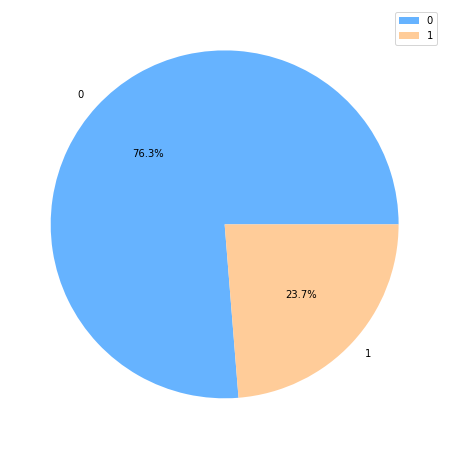

In [30]:
plt.figure(figsize = (12,8))
print(train['Is_Lead'].value_counts())
colors = ['#66b3ff','#ffcc99']
plt.pie(train['Is_Lead'].value_counts(), labels = ['0','1'], autopct='%.1f%%',colors= colors)
plt.legend()
plt.show()

***The dataset is quite imbalanced as 76% peoples are not not interested for Credit card and 24% are interested***

***Let's see gender wise customer's response on recommended credit cards.***

Text(0.5, 1.0, 'Gender Wise Customer Response in the Recommended Credit Cards')

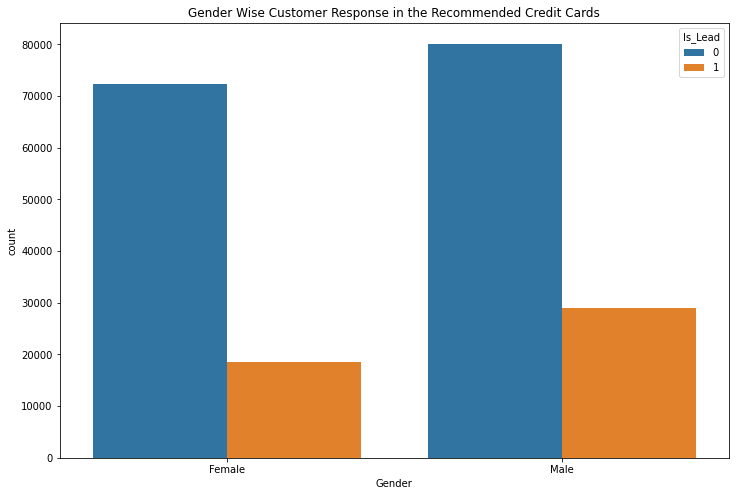

In [31]:
plt.figure(figsize = (12,8))
sns.countplot(x='Gender', hue='Is_Lead', data=train).set_title('Gender Wise Customer Response in the Recommended Credit Cards')

***The count plot shows that male customers are highly interests in recommended credit cards when compare to female customers.***

***The percentage of customers not interested in the recommended policies is high in both genders.***

Text(0.5, 1.0, 'Occupation Wise Customer Response in the Recommended Credit Cards')

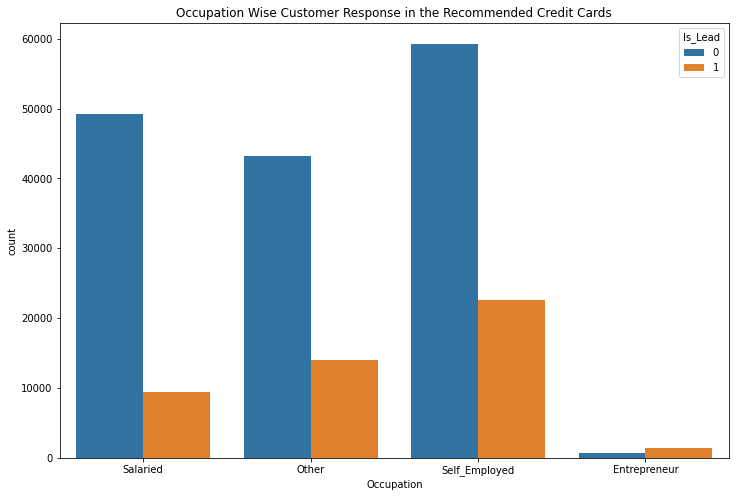

In [32]:
plt.figure(figsize = (12,8))
sns.countplot(x='Occupation', hue = 'Is_Lead', data = train).set_title('Occupation Wise Customer Response in the Recommended Credit Cards')

***Self employed people are highly interested in recomeended credit cards when comapared to others***

Text(0.5, 1.0, 'Channel Code Wise Customer Response in the Recommended Credit Cards')

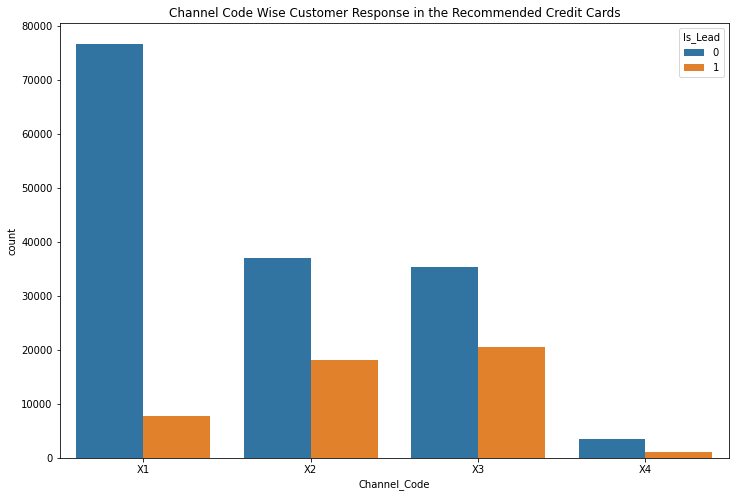

In [33]:
plt.figure(figsize = (12,8))
sns.countplot(x='Channel_Code', hue = 'Is_Lead', data = train).set_title('Channel Code Wise Customer Response in the Recommended Credit Cards')

***Channel X3 and X2 people are highly interested in recomeended credit cards when comapared to others, while people belongs to channel X1 are hihly non-interested in recommended credit cards.***

Text(0.5, 1.0, 'Channel Code Wise Customer Response in the Recommended Credit Cards')

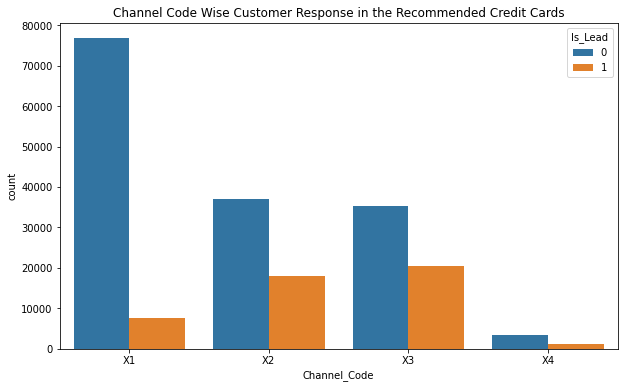

In [34]:
plt.figure(figsize = (10,6))
sns.countplot(x='Channel_Code', hue = 'Is_Lead', data = train).set_title('Channel Code Wise Customer Response in the Recommended Credit Cards')

<Axes: xlabel='Credit_Product', ylabel='count'>

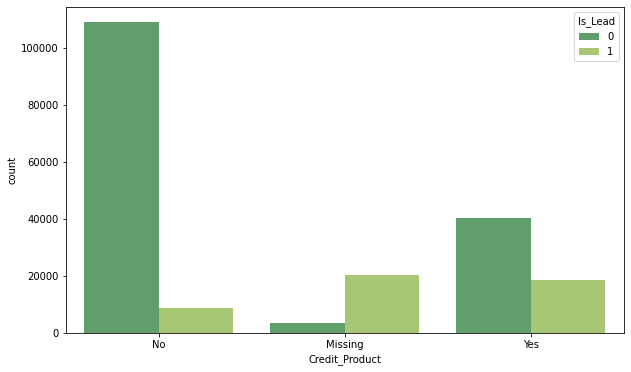

In [35]:
plt.figure(figsize = (10,6))
sns.countplot(data=train.fillna('Missing'), x='Credit_Product', hue='Is_Lead', palette='summer')

***It is very strange to observe that the missing values do actually have more leads. Thus we should fill the missing values.***

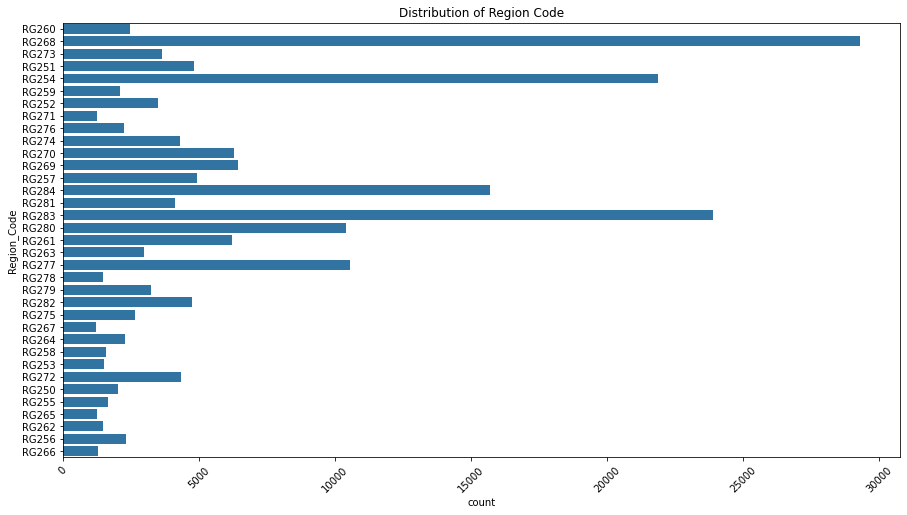

In [36]:
# Region_Code : Code of the Region for the customers

plt.figure(figsize=(15,8))
ax = sns.countplot(train.Region_Code)
#ax = sns.countplot(train.Region_Code, hue=train.Is_Lead)

ax.set_title('Distribution of Region Code')
plt.xticks(rotation=45)
plt.show()

* Each region has differnt trend
 
* Dummy Encoding of Region Code will increase complexity of Model and also preformance will be lowered
 
* Will use Lead Probabilty Score of each region instead of categories.


*probability_score = no_of_leads_in_region / no_of_customers_in_region*

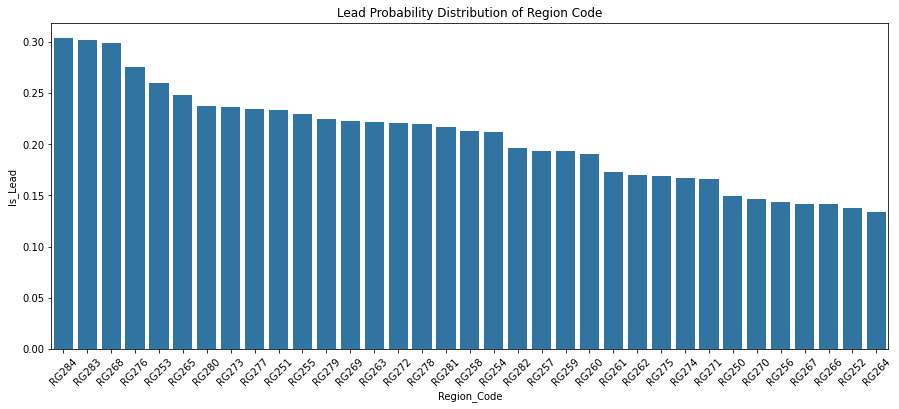

In [37]:
rc_encoding = train.groupby('Region_Code')['Is_Lead'].mean().reset_index()

plt.figure(figsize=(15,6))
ax = sns.barplot(x='Region_Code', y='Is_Lead', data=rc_encoding.sort_values(by=['Is_Lead'], ascending=False));
ax.set_title('Lead Probability Distribution of Region Code')
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_292/2841360305.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(train.Avg_Account_Balance/10000)


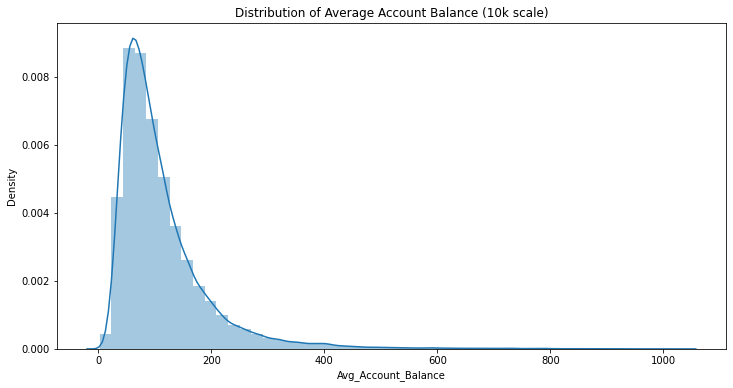

In [38]:
# Avg_Account_Balance : Average Account Balance for the Customer in last 12 Months

plt.figure(figsize=(12,6))
ax = sns.distplot(train.Avg_Account_Balance/10000)
ax.set_title('Distribution of Average Account Balance (10k scale)')
plt.show()

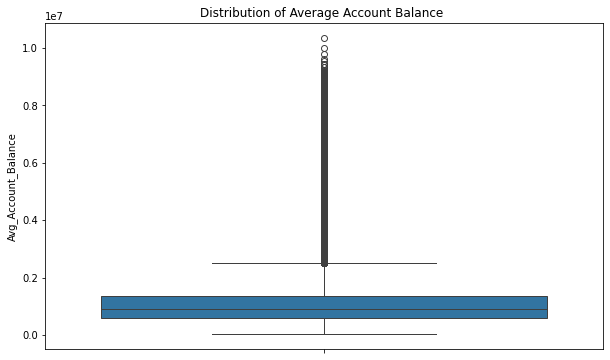

In [39]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(train.Avg_Account_Balance, orient = 'v')
ax.set_title('Distribution of Average Account Balance ')
plt.show()

*We have outliers in the Average Account Balance feature*

/tmp/ipykernel_292/1559974286.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(train.Age)


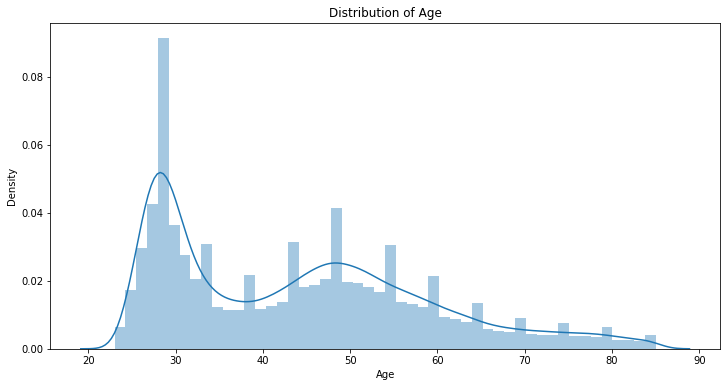

In [40]:
# Age: Age of the Customer (in Years)

plt.figure(figsize=(12, 6))
ax = sns.distplot(train.Age)
ax.set_title('Distribution of Age')
plt.show()

Text(0.5, 1.0, 'Distribution of Age')

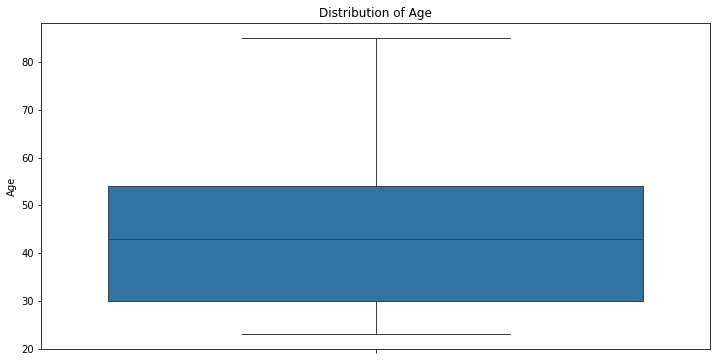

In [41]:
plt.figure(figsize=(12, 6))
sns.boxplot(train.Age).set_title("Distribution of Age")